In [1]:
# dependencies for file reading
import json
import sys
import itertools
import numpy as np
import os
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import librosa # conda install -c conda-forge librosa
import seaborn as sns

# managing parameters
from parammanager import paramManager
#from Tf_record import tfrecordManager

from genericsynth import synthInterface as SI
#Synth Interface (SI) is the base model for all synths, also some utilities 

#### Demo of raw sound model - 

1. The drip texture is generated by a continuous frequency sweep from start frequency (cf) to a range (sweep) of  frequency movement away from cf. <br>
2. The model is specified by four parameters, CF, sweep, decay, and decay variation <br>
3. CF is specified at the user level in config file <br>
4. Three synthesizer specific parameters control the timbre of the drip sound: <br>
    3.1 Sweep : Range of frequencies traveresed for the frequency sweep.
    3.2 Cutoff: The rate of the decay from starting amplitude to silence
    3.3 Starting amplitude: The starting amplitude of the sound  
    3.4 Starting frequency: Starting frequency for the sweep (50Hz with 200Hz of sweep sounds a bit realistic) 
5. A synthesizer loop runs through the parameter values for a specified duration to generate drip audio samples

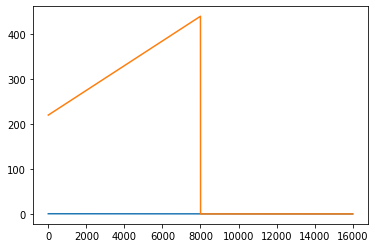

In [2]:
# Gestures: A transformation function specifying changes about an aspect of a sound.
# Gestures: Amplitude envelopes and frequency sweeps.
# Gestures are part of the generic synth model
#Gesture : start,stop, cutoff, numSamples

amp_env = SI.gesture(0.4,0.05, 0.5, 16000)
freq_sweep = SI.gesture(220,440,0.5, 16000)
plt.plot(amp_env)
plt.plot(freq_sweep)

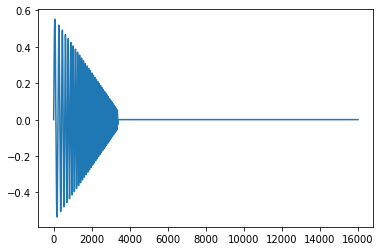

In [3]:
import math

'''Interface level parameters''' 
cf = np.random.randint(55,220) #spanning 2 octaves
Q = 220

'''Synth variables'''
start_Hz = cf
stop_Hz = cf + Q
start_amp = 0.05 + np.random.random()
stop_amp = 0.05
cutOff = 0.05 + 0.2*np.random.random()

'''Synth level parameters''' 
phase_increment = 2 * math.pi * start_Hz / 16000     # phase increment per sample
numSamples = int(1 * 16000)        # 1 second * 16000 sample rate
phase = 0
phi = 0
synth_output = []

amp_env = SI.gesture(start_amp, stop_amp, cutOff,numSamples)
freq_sweep = SI.gesture(start_Hz, stop_Hz, cutOff, numSamples)

'''Drip Sample generation'''
for index in range(numSamples):

    A = amp_env[index]
    val = A * math.sin(phase + phi);    # output sample value for current sample
    phi += phase_increment;             # increment phase accumulator
    inst_f = freq_sweep[index]
    #f += freq_increment;                # increment instantaneous frequency
    phase_increment = 2 * math.pi * inst_f / 16000;  # re-calculate phase
    synth_output.append(val)

plt.plot(synth_output)
display(Audio(synth_output, rate=16000, autoplay=True))

#### Demo of synth interface using the single pop synth 

Note: MyPop and myDripPatternSynth are both synths that derive from the SI.MySoundModel class (and thus have the interface for parameter setting/getting as well as the generate() function for creating audio.

Here we load myPop just to see the interface in action. Normally it would only be used by myDripPatternSynth, and not loaded in a notebook or data set generating program. 

In [4]:
from myDrip import MyDrip  # This is the single-event synth that myDripPatternSynth uses [loading just for viz purposes]
foosynth=MyDrip(440, 50, 5, 2)   # can (optionally) set params for a synth when you create an instance

foosynth.setParam('cf', 440) # Can set any synth parameter with setParam()
foosynth.getParam('cf')    # Get a param value. 

440

In [5]:
fmin = foosynth.getParam('cf', "min")  # by default, getParam would get val, but here we ask for its min
print("min val of synth param f0 is {}".format(fmin))

foosynth.setParamNorm('cf', 1)   #setParamNorm uses [0,1] range 
print("now the value of synth param f0 is {}".format(   foosynth.getParam('cf')    ))

min val of synth param f0 is 110
now the value of synth param f0 is 440


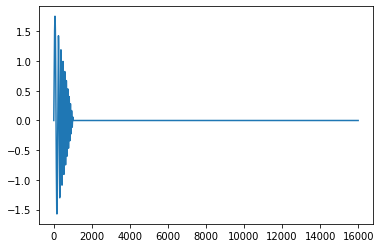

In [6]:
foosynth.setParam('cf', 55) # Can set any synth parameter with setParam()
foosynth.setParam('sweep', 220) # Can set any synth parameter with setParam()
foosynth.setParamNorm('startAmp', 1) # Can set any synth parameter with setParam()
foosynth.setParamNorm('ampRange', 0.4) # Can set any synth parameter with setParam()
sig=foosynth.generate(1)   # all synths use generate to create audio. Parameter is length in seconds
plt.plot(sig)
display(Audio(sig, rate=16000, autoplay=True))

#### Demo of synth interface using the MyDripPatternSynth

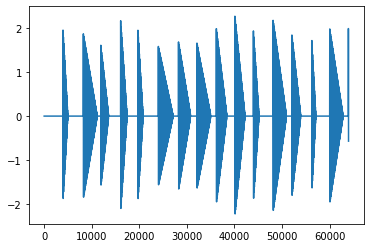

In [7]:
from myDripPatternSynth import MyDripPatternSynth

barsynth=MyDripPatternSynth()

barsynth.setParamNorm('cf', 0.75) # Can set any synth parameter with setParam()
barsynth.setParamNorm('sweep', 1) # Can set any synth parameter with setParam()
barsynth.setParamNorm('startAmp', 1) # Can set any synth parameter with setParam()
barsynth.setParamNorm('ampRange', 0.25) # Can set any synth parameter with setParam()
barsynth.setParam("rate_exp",2) # will make 2^1 events per second
barsynth.setParam("irreg_exp", 0.25)

barsig=barsynth.generate(4)      #generates 4 seconds of drip sound
plt.plot(barsig)
display(Audio(barsig, rate=16000, autoplay=True))

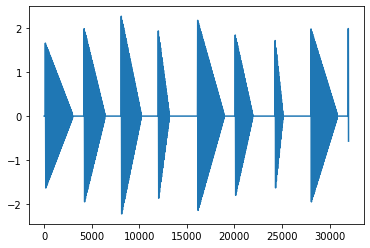

In [8]:
#Chunking the drip sounds into smaller segments for training/test data sets
chunkedAudio = SI.selectVariation(barsig, 16000, 1, 2)
plt.plot(chunkedAudio)
display(Audio(chunkedAudio, rate=16000, autoplay=True))

### Visualize distribution of events

Notice that this code is model-independent (uses only SI utility function, no synth methods)

number of events is 8000


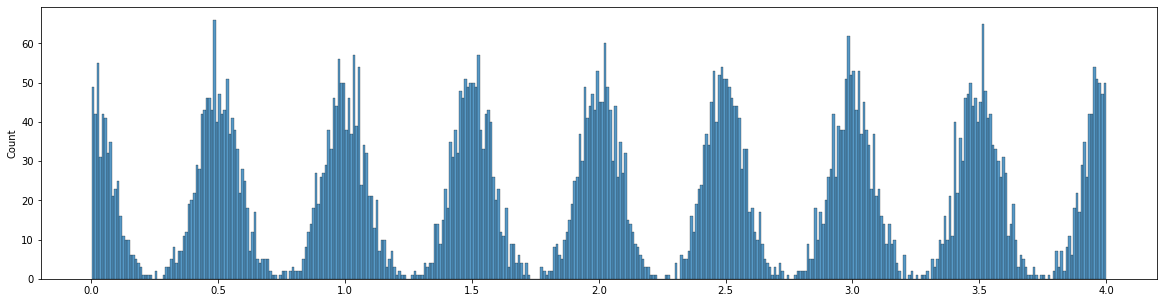

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

events=[]
for i in range(1000) :  #repeat to get enought samples to see the shape of the distribution
                                        #params: (events per second = 2^p1,     sd = .1*p2*10^p2,     seconds)
    events.extend(SI.noisySpacingTimeList(1, .5, 4))
print("number of events is {}".format(len(events)))
plt.figure(figsize=(20,5))
sns.histplot(events, bins=400)
plt.show()


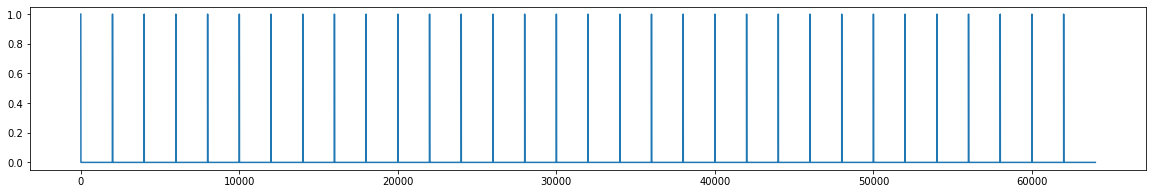

In [10]:
   #params: (events per second = 2^p1,     sd = .1*p2*10^p2,     seconds=p3)
elist = SI.noisySpacingTimeList(3, 0, 4)
esig = SI.timeList2Sig(elist,16000,4)

plt.figure(figsize=(20,3))
plt.plot(esig)

#### Demo of synth interface for dataset generation
1) Reading parameters from config_file.json <br>
2) Enumerating parameter values. <br>
3) Generating datasets from enumerated parameters

In [11]:
paramArr = []
data = []

config_file = './config_file.json'
with open(config_file) as json_file:
	data = json.load(json_file)
	print("Reading parameters for generating ", data['soundname'], " texture.. ")
	for p in data['params']:
	    print(p['pname'], ' Min: ', p['minval'], ' Max: ', p['maxval'])
	    paramArr.append(p)

sr = data["samplerate"]

Reading parameters for generating  drip_sound  texture.. 
rate  Min:  0  Max:  1
irreg  Min:  0  Max:  1
cf  Min:  0  Max:  1


In [12]:
cartParam = []

for p in paramArr:
        cartParam.append(np.linspace(p["minval"], p["maxval"], p["nvals"], endpoint=True))

enumParam = list(itertools.product(*cartParam))
str = '('
for p in data['params']:
    str = str + p['pname'] + ','    
str = str + ')'
print("Enumerated parameter values", str)
enumParam

Enumerated parameter values (rate,irreg,cf,)


[(0.0, 0.0, 0.0),
 (0.0, 0.0, 1.0),
 (0.0, 1.0, 0.0),
 (0.0, 1.0, 1.0),
 (1.0, 0.0, 0.0),
 (1.0, 0.0, 1.0),
 (1.0, 1.0, 0.0),
 (1.0, 1.0, 1.0)]

#### Generate wav and param files for every parameter combination (listed above)

In [13]:
import soundfile as sf
from filewrite import fileHandler

'''Initializes file through a filemanager'''
fileHandle = fileHandler()

false = True # Change this to true for dataset generation

if false: 

    for enumP in enumParam: # caretesian product of lists
        
        #set parameters
        barsynth=MyDripPatternSynth()

        barsynth.setParam("rate_exp", enumP[0]) # will make 2^1 events per second
        barsynth.setParam("irreg_exp", enumP[1])
        barsynth.setParamNorm("cf", enumP[2])

        # Synth level parameters
        barsynth.setParamNorm('sweep', 1) # Can set any synth parameter with setParam()
        barsynth.setParamNorm('startAmp', 1) # Can set any synth parameter with setParam()
        barsynth.setParamNorm('ampRange', 0.25) # Can set any synth parameter with setParam()
        
        barsig=barsynth.generate(data["soundDuration"])

        varDurationSecs=data["soundDuration"]/data["numVariations"]  #No need to floor this?

        for v in range(data['numVariations']):

                '''Write wav'''
                wavName = fileHandle.makeName(data['soundname'], paramArr, enumP, v)
                wavPath = fileHandle.makeFullPath(data["outPath"],wavName,".wav")
                chunkedAudio = SI.selectVariation(barsig, sr, v, varDurationSecs)
                sf.write(wavPath, chunkedAudio, sr)

                '''Write params'''
                paramName = fileHandle.makeName(data['soundname'], paramArr, enumP, v)
                pfName = fileHandle.makeFullPath(data["outPath"], paramName,".params")
                #print(pfName)
                pm=paramManager.paramManager(pfName, fileHandle.getFullPath())
                pm.initParamFiles(overwrite=True)
                for pnum in range(len(paramArr)):
                        pm.addParam(pfName, paramArr[pnum]['pname'], [0,data['soundDuration']], [enumP[pnum], enumP[pnum]], units=paramArr[pnum]['units'], nvals=paramArr[pnum]['nvals'], minval=paramArr[pnum]['minval'], maxval=paramArr[pnum]['maxval'])

                '''write TF record'''
                #tfm=tfrecordManager.tfrecordManager(vFilesParam[v], outPath)
                #data,sr = librosa.core.load(outPath + fname + '--v-'+'{:03}'.format(v)+'.wav',sr=16000)
                #print(len(data))
                #tfm.addFeature(vFilesParam[v], 'audio', [0,len(data)], data, units='samples', nvals=len(data), minval=0, maxval=0)
                #for pnum in range(len(paramArr)):
                #	print(pnum)
                #	tfm.addFeature(vFilesParam[v], paramArr[pnum]['pname'], [0,data['soundDuration']], [enumP[pnum], enumP[pnum]], units=paramArr[pnum]['units'], nvals=paramArr[pnum]['nvals'], minval=paramArr[pnum]['minval'], maxval=paramArr[pnum]['maxval'])
                #tfm.writeRecordstoFile()


drip_sound--rate-00.00--irreg-00.00--cf-00.00--v-000.params 
drip_sound--rate-00.00--irreg-00.00--cf-00.00--v-001.params 
drip_sound--rate-00.00--irreg-00.00--cf-01.00--v-000.params 
drip_sound--rate-00.00--irreg-00.00--cf-01.00--v-001.params 
drip_sound--rate-00.00--irreg-01.00--cf-00.00--v-000.params 
drip_sound--rate-00.00--irreg-01.00--cf-00.00--v-001.params 
drip_sound--rate-00.00--irreg-01.00--cf-01.00--v-000.params 
drip_sound--rate-00.00--irreg-01.00--cf-01.00--v-001.params 
drip_sound--rate-01.00--irreg-00.00--cf-00.00--v-000.params 
drip_sound--rate-01.00--irreg-00.00--cf-00.00--v-001.params 
drip_sound--rate-01.00--irreg-00.00--cf-01.00--v-000.params 
drip_sound--rate-01.00--irreg-00.00--cf-01.00--v-001.params 
drip_sound--rate-01.00--irreg-01.00--cf-00.00--v-000.params 
drip_sound--rate-01.00--irreg-01.00--cf-00.00--v-001.params 
drip_sound--rate-01.00--irreg-01.00--cf-01.00--v-000.params 
drip_sound--rate-01.00--irreg-01.00--cf-01.00--v-001.params 
